In [1]:
import openai
import time
import re
import requests
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
from sklearn.metrics import accuracy_score, f1_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load API key and endpoint info from Azure AI
load_dotenv()
openai.api_type = "azure"
openai.api_version = "2023-05-15" 
openai.api_base = os.getenv("ENDPOINT")  
openai.api_key = os.getenv("KEY1")

In [3]:
df = pd.read_csv('../../data/phmrc/phmrc_adult_tokenized.csv')

In [4]:
label_to_score = {
    'aids-tb': 0,
    'communicable': 1,
    'external': 2,
    'maternal': 3, 
    'non-communicable': 4
}

score_to_label = {
    0: 'aids-tb',
    1: 'communicable',
    2: 'external',
    3: 'maternal',
    4: 'non-communicable' 
}

In [5]:
def get_embedding(label: str) -> float:
    label = label.lower()
    if label not in label_to_score:
        print(label)
        return 0
    return label_to_score[label]

In [6]:
prompt_template = """
<narrative>
INPUT
</narrative>

<labels>
aids-tb: Patient died resulting from HIV-AIDs or Tuberculosis.
communicable: Patient died from a communicable disease which is defined as 
illnesses that spread from one human to another such as pneumonia, diarrhea 
or dysentery.
external: Patient died from external causes including as accidents like fires,
drowning, road traffic, falls, poisonous animals and violence like suicide, 
homicide, or other injuries.
maternal: Patient died from complications related to pregnancy or childbirth 
including from severe bleeding, sepsis, pre-eclampsia and eclampsia.
non-communicable: Patient died from a non-communicable disease which is defined
as illnesses that cannot be transmitted from one human to another such as cirrhosis,
epilepsy, acute myocardial infarction, copd, renal failure, cancer, diabetes,
stroke, malaria, asthma, or other non-communicable diseases.
</labels>

<options>
aids-tb, 
communicable, 
external, 
maternal, 
non-communicable
</options>


Which label best applies applies to the narrative (aids-tb, communicable, external, maternal, non-communicable)?
Limit your response to one of the options exactly as it appears in the list.
"""

# remove \n
prompt_template = prompt_template.replace('\n', '')

In [7]:
def inspect_narrative(row):
    print('Narrative: ' + df['narrative'][row])
    print('True Label: ' + df['gs_text34'][row])
    print('Broad Category: ' + df['gs_cod'][row])
    print('Embedding Representation: ' + str(label_to_score[df['gs_cod'][row]]))

In [8]:
inspect_narrative(5)

Narrative: the deceased had been burnt and had lost mental balance and died within 1.5 hours of the accident.
True Label: fires
Broad Category: external
Embedding Representation: 2


# Test it on a single example

In [84]:
# try by inputting a specific text narrative
text = df['narrative'][5]

# call model
response = None
while response is None:
    try:
        response = openai.ChatCompletion.create(
        engine="gpt-35-turbo-0301",
        messages=[
                {"role": "user", "content": prompt_template.replace("INPUT", text)}
            ],
        temperature=0
        )
    except Exception as e:
        print(e)
        time.sleep(1)
        
score = get_embedding(response["choices"][0]["message"]["content"])
print(response["choices"][0]["message"]["content"])
print(score)

external
2


# Zero Shot Prediction on all data.

In [38]:
# # run all narratives

# zeroshot_predictions = []

# for narrative in tqdm(df['narrative']):
#     # call model
#     response = None
#     while response is None:
#         try:
#             response = openai.ChatCompletion.create(
#             engine="gpt-35-turbo-0301",
#             messages=[
#                     {"role": "user", "content": prompt_template.replace("INPUT", narrative)}
#                 ],
#             temperature=0
#             )
#         except Exception as e:
#             print(e)
#             time.sleep(1)

#     score = response["choices"][0]["message"]["content"]
#     zeroshot_predictions.append(score)

100%|███████████████████████████████████████| 6763/6763 [26:38<00:00,  4.23it/s]


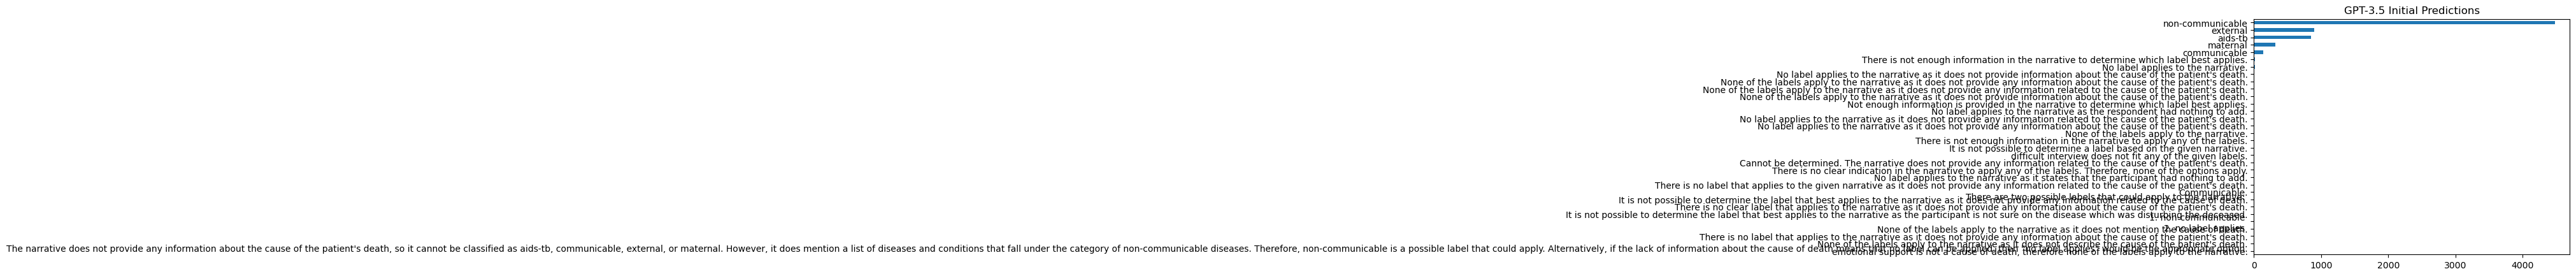

In [40]:
pd.Series(zeroshot_predictions).value_counts().plot.barh(title='GPT-3.5 Zeroshot Text Predictions').invert_yaxis()

In [9]:
# get embeddings for text predictions. If prediction not in list, use 'non-communicable'
cod_list = ['aids-tb', 'communicable', 'external', 'maternal', 'non-communicable']
zeroshot_scores = [get_embedding(x) if x in cod_list else get_embedding('non-communicable') for x in zeroshot_predictions]

NameError: name 'zeroshot_predictions' is not defined

In [ ]:
# write out to csv
pd.Series(zeroshot_predictions).to_csv("gpt35_zeroshot_text.csv", index=False)
pd.Series(zeroshot_scores).to_csv("gpt35_zeroshot_score.csv", index=False)

In [ ]:
# plot scores distribution
pd.Series(predictions_score).value_counts().plot.barh(title='GPT-3.5 Zeroshot Score Predictions').invert_yaxis()

## Few Shot Prediction on all data

In [10]:
# function to take in dataframe and output fewshot prompting examples in JSON format
def make_fewshot_examples(input_df, n):
    '''
    this function takes in a pandas dataframe and number of examples n
    takes a random subset of size n from df
    for each row in df, creates a user/assistant prompt example
    returns all few shot examples in JSON format
    '''
    
    df = input_df.sample(n)
    
#     df['gs_cod'].value_counts().plot(kind='barh', title='COD Distribution for Subsample')
    df['site'].value_counts().plot(kind='barh', title='Site Distribution for Subsample')

    
    messages = []
    
    for i, narratives in tqdm(df.iterrows()):
        narrative = narratives['narrative']
        label = narratives['gs_cod']
        
        messages.append({"role": "user", "content": narrative})
        messages.append({"role": "assistant", "content": label})
        
    return messages

50it [00:00, 12425.36it/s]


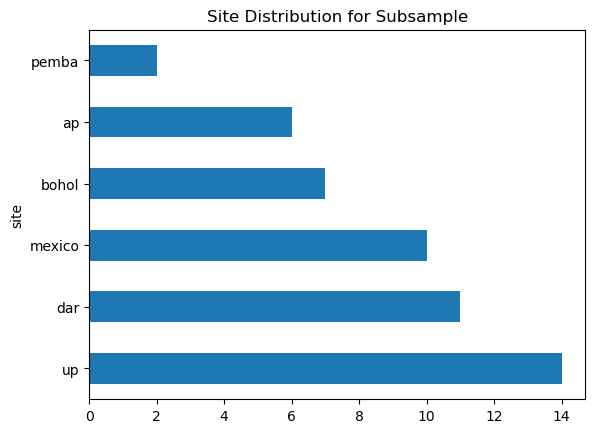

In [19]:
# select few shot examples
random.seed(1)
fewshot_examples = make_fewshot_examples(df, 50)

In [20]:
# run all narratives

fewshot_predictions = []

for narrative in tqdm(df['narrative']):
    # call model
    response = None
    while response is None:
        try:
            response = openai.ChatCompletion.create(
            engine="gpt-35-turbo-0301",
            messages=fewshot_examples + [{"role": "user", "content": prompt_template.replace("INPUT", narrative)}],
            temperature=0
            )
        except Exception as e:
            print(e)
            time.sleep(1)

    score = response["choices"][0]["message"]["content"]
    fewshot_predictions.append(score)

100%|███████████████████████████████████████| 6763/6763 [45:24<00:00,  2.48it/s]


In [21]:
# convert text to scores
fewshot_scores = [get_embedding(x) if x in cod_list else get_embedding('non-communicable') for x in fewshot_predictions]

# write out to csv
pd.Series(fewshot_predictions).to_csv("gpt35_fewshot_text.csv", index=False)
pd.Series(fewshot_scores).to_csv("gpt35_fewshot_score.csv", index=False)

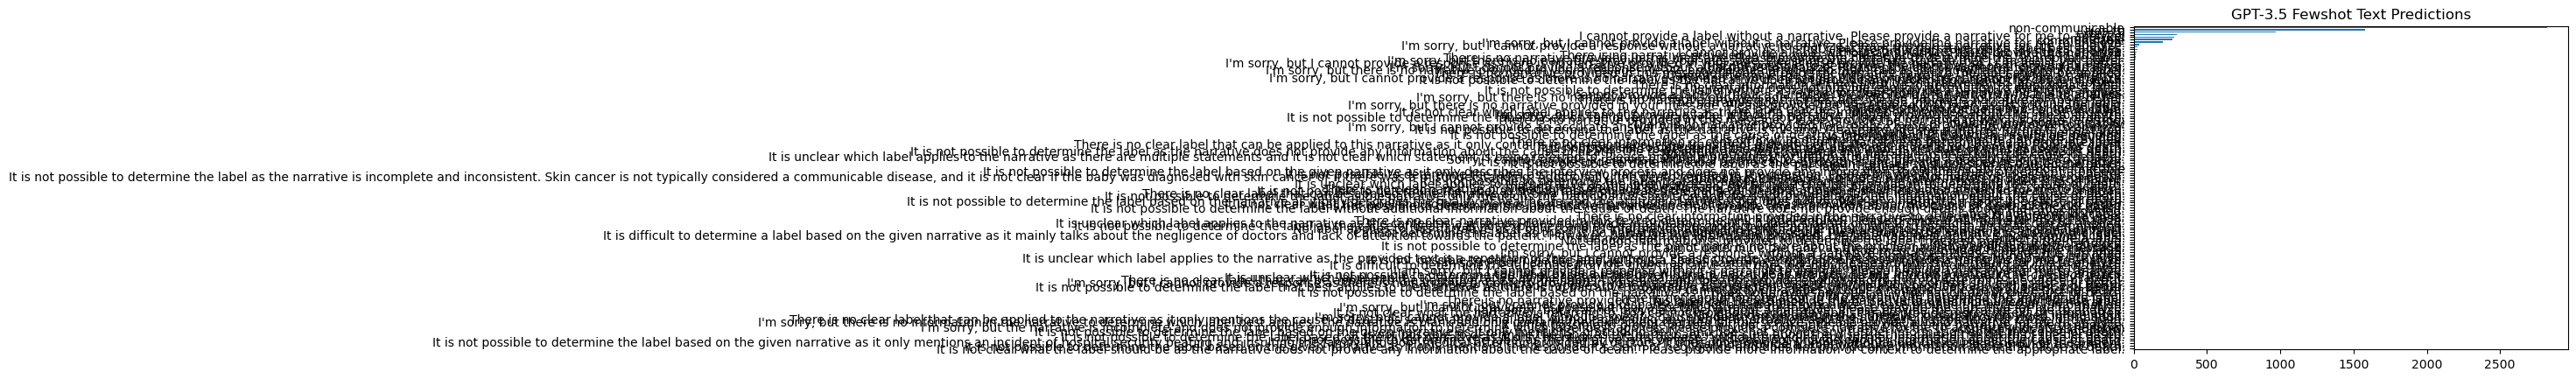

In [22]:
# plot text score dist
pd.Series(fewshot_predictions).value_counts().plot.barh(title='GPT-3.5 Fewshot Text Predictions').invert_yaxis()

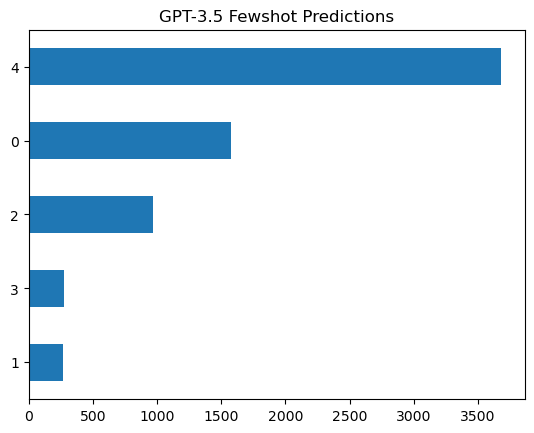

In [23]:
# plot text score dist
pd.Series(fewshot_scores).value_counts().plot.barh(title='GPT-3.5 Fewshot Predictions').invert_yaxis()

## Compute and Compare Accuracy

In [25]:
predictions_classic = pd.read_csv('../classic_nlp/baseline_predictions.csv')
# predictions_bert = pd.read_csv('../transformer_nlp/ansformer_nlp/predictions_bert.csv')
predictions_gtp35_zeroshot = pd.read_csv('gpt35_zeroshot_score.csv')
predictions_gtp35_fewshot = pd.read_csv('gpt35_fewshot_score.csv')

In [26]:
accuracy_df = predictions_classic.copy()
# accuracy_df['predictions_BERT'] = predictions_bert
accuracy_df['predictions_GPT35_zeroshot'] = predictions_gtp35_zeroshot
accuracy_df['predictions_GPT35_fewshot'] = predictions_gtp35_fewshot

accuracy_df = accuracy_df.rename(columns={"predictions_NB": "NB", 
                            "predictions_SVM": "SVM", 
                            "predictions_KNN": "KNN",
                            "predictions_GPT35_zeroshot": "GPT35_zeroshot",
                            "predictions_GPT35_fewshot": "GPT35_fewshot"})

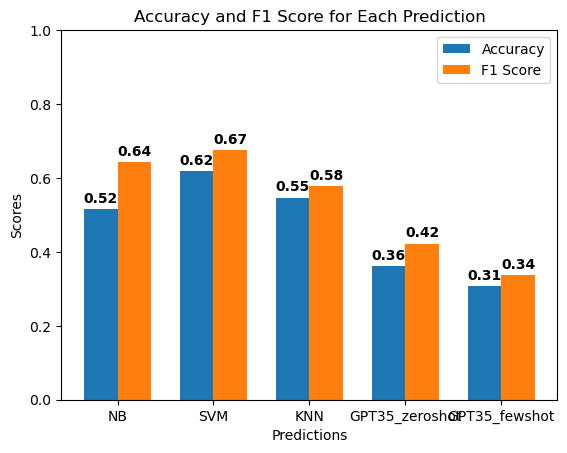

In [28]:
# Calculate accuracy and F1 score for each prediction column
columns_to_evaluate = ['NB', 'SVM', 'KNN', 'GPT35_zeroshot', 'GPT35_fewshot']
accuracy_scores = []
f1_scores = []

for column in columns_to_evaluate:
    accuracy = accuracy_score(accuracy_df[column], accuracy_df['Test_Y'])
    f1 = f1_score(accuracy_df[column], accuracy_df['Test_Y'] , average = 'weighted')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Plot the results
fig, ax = plt.subplots()

bar_width = 0.35
index = np.arange(len(columns_to_evaluate))

bar1 = ax.bar(index, accuracy_scores, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, f1_scores, bar_width, label='F1 Score')

ax.set_xlabel('Predictions')
ax.set_ylabel('Scores')
ax.set_title('Accuracy and F1 Score for Each Prediction')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(columns_to_evaluate)
ax.legend()
# Set y-axis range to 0-1
ax.set_ylim(0, 1)

# Add scores on top of each bar
for i, (acc, f1) in enumerate(zip(accuracy_scores, f1_scores)):
    ax.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom', color='black', fontweight='bold')
    ax.text(i + bar_width, f1 + 0.01, f'{f1:.2f}', ha='center', va='bottom', color='black', fontweight='bold')

plt.show()

In [29]:
import sys

In [30]:
print("Python version: ", sys.version)

Python version:  3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
